In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import warnings

# Set the display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

student_data = pd.read_csv("/Users/srisatyaindukuri/Spider/ML - Curricular Analytics - PIDM ONLY & Fixed Repeat IND.csv")
# Replace '-' with NaN
student_data.replace('-', np.nan, inplace=True)
print(student_data.sample(5))



/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_13513/1674999812.py:18: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  student_data = pd.read_csv("/Users/srisatyaindukuri/Spider/ML - Curricular Analytics - PIDM ONLY & Fixed Repeat IND.csv")


            Pidm Admit_Code                      Admit_Desc  Admit_Term Admit_Level Admit_College Admit_Major_Code              Major_Desc Trump_Race     Trump_Race_Desc MULTI     Race           NEW_ETHNICITY GENDER_Code  GENDER CITZ_IND CITZ_CODE      CITZ_DESC  Final_GPA ACTE ACTM ACTR ACTS EACT SAT-ERW SATM SAT_TOTAL      Term      CRN SUBJ CRSE_NUMB REPEAT_IND FINAL_GRADE
1761628  3498690         JU  Fl Comm Coll Transf-Upper Levl      201908          UG            SA              HLS         Health Sciences          H  Hispanic or Latino   NaN      NaN      Hispanic or Latino           F  Female        Y         C  Citizen (USA)       3.36   20   16   23   19   20     570  460      1030  202101.0  11469.0  BSC     2086L          I           A
1299537  3372167         UL   Other UG Transf - Lower Level      201708          UG            SA              PGB  General Business (Pre)          W               White   NaN  W White  Not Hispanic or Latino           M    Male        Y     

In [3]:
# List of score columns
score_columns = ['ACTE', 'ACTM', 'ACTR', 'ACTS', 'EACT', 'SAT-ERW', 'SATM', 'SAT_TOTAL', 'Final_GPA']

# Convert score columns to numeric
for col in score_columns:
    student_data[col] = pd.to_numeric(student_data[col], errors='coerce')


In [4]:
# ACT to SAT conversion table
act_to_sat_conversion = {
    36: 1590, 35: 1540, 34: 1500, 33: 1460, 32: 1430, 31: 1400,
    30: 1370, 29: 1340, 28: 1310, 27: 1280, 26: 1240, 25: 1210,
    24: 1180, 23: 1140, 22: 1110, 21: 1080, 20: 1040, 19: 1010,
    18: 970, 17: 930, 16: 890, 15: 850, 14: 800, 13: 760,
    12: 710, 11: 670, 10: 630, 9: 590
}

# Convert EACT to SAT
def convert_act_to_sat(eact_score):
    if pd.isna(eact_score):
        return np.nan
    return act_to_sat_conversion.get(int(eact_score), np.nan)

# Apply the conversion to EACT scores
student_data['Converted_SAT'] = student_data['SAT_TOTAL']

# Identify where SAT_TOTAL is missing but EACT is available
mask = student_data['SAT_TOTAL'].isna() & student_data['EACT'].notna()

# Apply conversion
student_data.loc[mask, 'Converted_SAT'] = student_data.loc[mask, 'EACT'].apply(convert_act_to_sat)

# Step 4: Handle Remaining Missing Values

# Drop rows where Converted_SAT or Final_GPA is still NaN
datawithsat = student_data.dropna(subset=['Converted_SAT', 'Final_GPA'])

datawithsat.sample(5)





,Pidm,Admit_Code,Admit_Desc,Admit_Term,Admit_Level,Admit_College,Admit_Major_Code,Major_Desc,Trump_Race,Trump_Race_Desc,MULTI,Race,NEW_ETHNICITY,GENDER_Code,GENDER,CITZ_IND,CITZ_CODE,CITZ_DESC,Final_GPA,ACTE,ACTM,ACTR,ACTS,EACT,SAT-ERW,SATM,SAT_TOTAL,Term,CRN,SUBJ,CRSE_NUMB,REPEAT_IND,FINAL_GRADE,Converted_SAT
486461,3151813,JU,Fl Comm Coll Transf-Upper Levl,201901,UG,SA,EPIT,Pre-Information Technology,B,Black or African American,NaN,B Black or African American,Not Hispanic or Latino,M,Male,Y,C,Citizen (USA),3.26,15.0,16.0,14.0,16.0,15.0,NaN,NaN,NaN,201901.0,18729.0,EGS,3720,NaN,A,850.0
491492,3153354,BL,Beginner(FTIC) - Lower Level,201508,UG,SA,SPA,Spanish,W,White,NaN,W White,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),4.67,32.0,29.0,29.0,29.0,30.0,NaN,NaN,NaN,201805.0,55178.0,CPO,4930,NaN,A+,1370.0
1598731,3459362,UL,Other UG Transf - Lower Level,201805,UG,SA,PNR,Pre-Nursing,W,White,NaN,W White,Not Hispanic or Latino,M,Male,Y,C,Citizen (USA),3.44,NaN,NaN,NaN,NaN,NaN,610.0,540.0,1150.0,202008.0,87136.0,EVR,4027,NaN,A,1150.0
2071259,3578972,BL,Beginner(FTIC) - Lower Level,202008,UG,SA,MAS,Mass Communications,W,White,NaN,W White,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),4.26,NaN,NaN,NaN,NaN,NaN,640.0,580.0,1220.0,202401.0,14816.0,SLS,3308,NaN,C-,1220.0
133743,2890524,JU,Fl Comm Coll Transf-Upper Levl,201601,UG,SP,HSP,Health Sciences,B,Black or African American,NaN,B Black or African American,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),3.98,17.0,16.0,22.0,17.0,18.0,NaN,NaN,NaN,201708.0,87813.0,ENC,2210,NaN,A,970.0


In [5]:
# Define passing and failing grades
passing_grades = ['A+','A','A*','C-*', 'A-','A-*','S*','B*', 'B+', 'B', 'B-', 'C+', 'C', 'C-','S','WC','WE','CM','C*','A+*','B-*','C+*','CC','N','CC+', 'CD', 'CB', 'CB-', 'CD-', 'CU', 'CA','B+*','CB+', 'CA-','C-#', 'B+#', 'CC-' 'CS', 'CD+', 'CA+','B#','A#','CC-', 'CS']
failing_grades = ['F', 'IF', 'W','D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-','U','W','F*','D*','CF','I','FF','Z','W*', 'F+', 'F-', 'F#', 'F*','D-*','IF','IF*', 'D+*','CIF','Z*', 'IU','M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']

# Create Pass_Fail column
datawithsat['Pass_Fail'] = datawithsat['FINAL_GRADE'].apply(
    lambda x: 1 if x in passing_grades else 0 if x in failing_grades else np.nan
)

# Drop rows with undefined grades
datawithsat = datawithsat.dropna(subset=['Pass_Fail']) # Drop rows with undefined grades (have to recheck about 5477 rows deleted)

datawithsat.sample(25)


/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_13513/186037628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datawithsat['Pass_Fail'] = datawithsat['FINAL_GRADE'].apply(


,Pidm,Admit_Code,Admit_Desc,Admit_Term,Admit_Level,Admit_College,Admit_Major_Code,Major_Desc,Trump_Race,Trump_Race_Desc,MULTI,Race,NEW_ETHNICITY,GENDER_Code,GENDER,CITZ_IND,CITZ_CODE,CITZ_DESC,Final_GPA,ACTE,ACTM,ACTR,ACTS,EACT,SAT-ERW,SATM,SAT_TOTAL,Term,CRN,SUBJ,CRSE_NUMB,REPEAT_IND,FINAL_GRADE,Converted_SAT,Pass_Fail
2236869,3635599,BL,Beginner(FTIC) - Lower Level,202108,UG,SA,HSS,Health Sciences,A,Asian,NaN,A Asian,Not Hispanic or Latino,M,Male,Y,C,Citizen (USA),4.37,NaN,NaN,NaN,NaN,NaN,650.0,680.0,1330.0,202301.0,18034.0,PCB,3063L,NaN,B,1330.0,1.0
1163287,3339509,BL,Beginner(FTIC) - Lower Level,201705,UG,SA,PGB,General Business (Pre),H,Hispanic or Latino,NaN,NaN,Hispanic or Latino,M,Male,Y,C,Citizen (USA),3.72,NaN,NaN,NaN,NaN,NaN,650.0,570.0,1220.0,201808.0,87908.0,ENC,3250,NaN,B-,1220.0,1.0
2069014,3578592,BL,Beginner(FTIC) - Lower Level,202005,UG,SA,POL,Political Science,B,Black or African American,NaN,B Black or African American,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),4.19,24.0,23.0,24.0,24.0,24.0,NaN,NaN,NaN,202105.0,59265.0,IDS,3947,NaN,S,1180.0,1.0
2144405,3604649,BL,Beginner(FTIC) - Lower Level,202005,UG,SP,PMR,Marketing (Pre),W,White,NaN,W White,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),3.65,NaN,NaN,NaN,NaN,NaN,580.0,580.0,1160.0,202205.0,57291.0,QMB,2100,NaN,C,1160.0,1.0
598837,3184017,BL,Beginner(FTIC) - Lower Level,201505,UG,SA,POL,Political Science,W,White,NaN,W White,Not Hispanic or Latino,M,Male,Y,C,Citizen (USA),3.29,30.0,26.0,23.0,24.0,26.0,NaN,NaN,NaN,201601.0,10002.0,AFR,1120,NaN,B,1240.0,1.0
2479902,3723200,BL,Beginner(FTIC) - Lower Level,202205,UG,AC,PSY,Psychology,H,Hispanic or Latino,NaN,W White,Hispanic or Latino,F,Female,Y,C,Citizen (USA),3.58,19.0,19.0,21.0,19.0,20.0,NaN,NaN,NaN,202301.0,10796.0,BSC,2010,NaN,B,1040.0,1.0
2400287,3690278,BL,Beginner(FTIC) - Lower Level,202208,UG,EN,CYR,Cybersecurity,W,White,NaN,W White,Not Hispanic or Latino,M,Male,Y,C,Citizen (USA),4.19,NaN,NaN,NaN,NaN,NaN,630.0,730.0,1360.0,202301.0,21107.0,COP,2513,NaN,A+,1360.0,1.0
726831,3212787,BL,Beginner(FTIC) - Lower Level,201601,UG,SP,ETB,Entrepreneurship & Innovation,A,Asian,NaN,A Asian,Not Hispanic or Latino,F,Female,Y,C,Citizen (USA),4.29,23.0,26.0,27.0,25.0,25.0,NaN,NaN,NaN,201601.0,22340.0,CHM,2020,NaN,A,1210.0,1.0
2190044,3625116,BL,Beginner(FTIC) - Lower Level,202108,UG,SA,BMS,Biomedical Sciences,F,Non-Resident Alien,NaN,NaN,Not Hispanic or Latino,F,Female,N,F,Foreign National,4.23,NaN,NaN,NaN,NaN,NaN,610.0,620.0,1230.0,202108.0,80055.0,CHM,2045,NaN,B+,1230.0,1.0
922568,3272736,BL,Beginner(FTIC) - Lower Level,201605,UG,SA,CSD,Communication Sci & Disorders,H,Hispanic or Latino,NaN,W White,Hispanic or Latino,M,Male,Y,C,Citizen (USA),3.52,22.0,23.0,24.0,25.0,24.0,NaN,NaN,NaN,201808.0,93480.0,INT,4947,NaN,A,1180.0,1.0


In [6]:
# Features: Final_GPA and Converted_SAT
features = ['Final_GPA', 'Converted_SAT']
X = datawithsat[features]
y = datawithsat['Pass_Fail']

In [7]:
#Split the Data into Dev Set and Remaining Data

# First, split off the dev set (10% of the data)
X_dev, X_remaining, y_dev, y_remaining = train_test_split(
    X, y, test_size=0.90, random_state=42, stratify=y
)

# Step 5: Split Remaining Data into Train and Test Sets

# Now split the remaining data into train and test sets
# For example, 80% train, 20% test of the remaining data
X_train, X_test, y_train, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.20, random_state=42, stratify=y_remaining
)

# Verify the splits
print(f"Total samples: {len(X)}")
print(f"Development samples: {len(X_dev)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Total samples: 2367798
Development samples: 236779
Training samples: 1704815
Test samples: 426204


In [8]:
# Step 6: Train the Decision Tree Model

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training set
dt_model.fit(X_train, y_train)

# Step 7: Hyperparameter Tuning Using Training Set Only

# Define a parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [9]:
# Use the best estimator to predict on the test set
best_dt_model = grid_search.best_estimator_
y_test_pred = best_dt_model.predict(X_test)
y_test_prob = best_dt_model.predict_proba(X_test)[:, 1]

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.8f}")


Test Set Accuracy: 0.92271541


In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Confusion Matrix:")
print(cm)


Test Set Confusion Matrix:
[[   400  32562]
 [   377 392865]]


In [ ]:
#Model has a high number of true positives and true negatives, but also a high number of false positives. The number of false negatives is relatively low.

In [11]:
# Classification Report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.01      0.02     32962
         1.0       0.92      1.00      0.96    393242

    accuracy                           0.92    426204
   macro avg       0.72      0.51      0.49    426204
weighted avg       0.89      0.92      0.89    426204



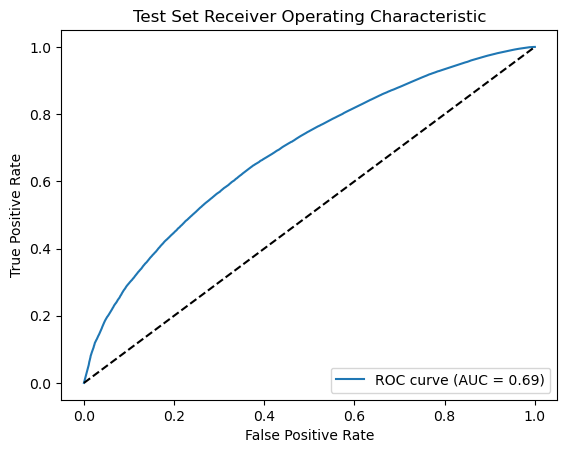

In [12]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

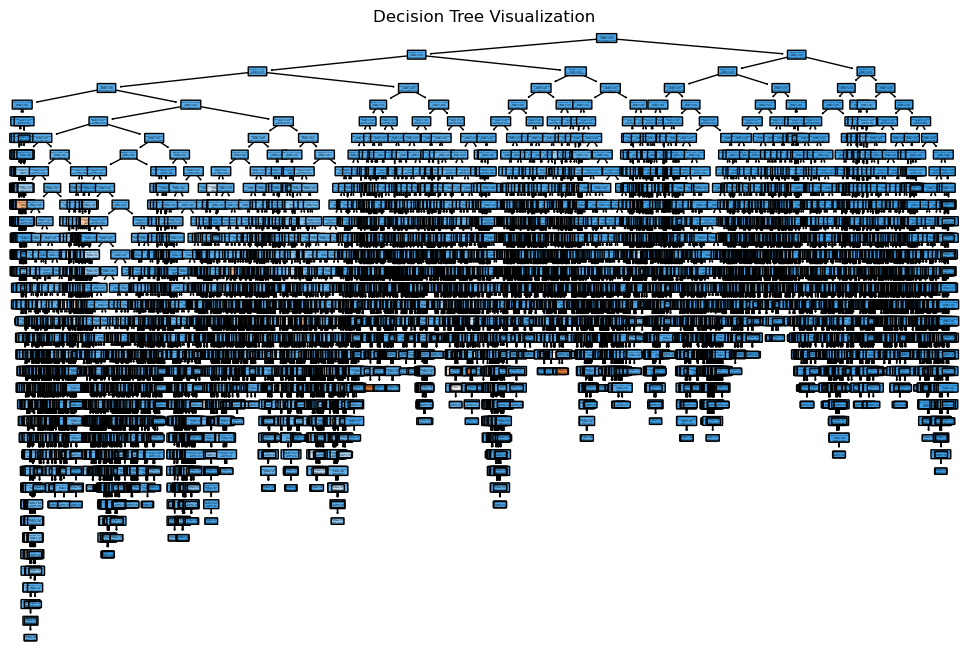

In [13]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    best_dt_model,
    feature_names=features,
    class_names=['Fail', 'Pass'],
    filled=True,
    rounded=True
)
plt.title('Decision Tree Visualization')
plt.show()


In [14]:
# Step 9: Interpret the Results

# Feature Importance
importance = best_dt_model.feature_importances_
for i, v in enumerate(importance):
    print(f'Feature: {features[i]}, Importance: {v:.5f}')

Feature: Final_GPA, Importance: 0.69324
Feature: Converted_SAT, Importance: 0.30676
